# Advanced quantitative techniques - Class 13 - Multilevel models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import QMSS as qmss

## 1. Multilevel modeling

In [2]:
sub = pd.read_csv('Data/GSS_Cum.csv', usecols=['sampcode', 'year', 'closeblk', 'race', 'age'])

In [3]:
# create community IDs
sub['sampyear'] = sub.sampcode*(10**4) + sub.year

#### The dependent variable - how close does one feel to blacks

In [4]:
sub.closeblk.value_counts()

5.0    5235
9.0    1854
7.0    1479
6.0    1020
8.0     698
1.0     686
4.0     502
3.0     490
2.0     333
Name: closeblk, dtype: int64

#### Calculate the percentage of African Americans in each community

In [5]:
# get race-level total for each sampyear
perc_black = sub.groupby('sampyear')['race'].value_counts().to_frame('pct_black')

# calculate percentage of each race out of total
perc_black = perc_black.groupby(level=0).apply(lambda x: 100*x/x.sum()).reset_index(drop=False)

perc_black = perc_black[perc_black.race==2]

In [6]:
sub = pd.merge(sub, perc_black[['sampyear', 'pct_black']], on='sampyear', how='left')
sub['pct_black'] = sub.pct_black.fillna(0)

In [7]:
sub.groupby('race')['pct_black'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
1,46350.0,9.929576,13.541160,0.0,0.000000,4.347826,16.000000,89.473684
2,7926.0,34.311056,22.235277,0.0,18.750000,31.250000,45.714286,100.000000
3,2785.0,12.321257,12.776410,0.0,1.960784,7.692308,19.354839,68.750000


In [8]:
# calculate number of observations in each cluster ('sampyear')
N_count = sub.groupby('sampyear')['year'].count().to_frame('N').reset_index(drop=False)
sub = pd.merge(sub, N_count[['sampyear', 'N']], on='sampyear', how='left')

# give each observation in a cluster a number from 1 through N
sub['n'] = sub.groupby('sampyear').cumcount()+1

### Naive OLS

In [9]:
# slide 15
sub = sub[sub.race!=3].copy()
sub['white'] = np.where(pd.isnull(sub.race), np.nan, 
                       np.where(sub.race==1, 1, 0))

# drop NA's
sub = sub.dropna()

In [291]:
from linearmodels import PooledOLS

# PooledOLS requires a multi-index dataframe where the level 0 index contains the entities and the level 1 contains the time
sub_panel = sub.set_index(['sampcode', 'year'], drop=False)

lm_closeblk = PooledOLS.from_formula('closeblk ~ 1 + white + pct_black + age + year', data=sub_panel).fit(cov_type='clustered', cluster_entity=True)
lm_closeblk.summary

Dep. Variable:,closeblk,R-squared:,0.1636
Estimator:,PooledOLS,R-squared (Between):,0.5560
No. Observations:,11260,R-squared (Within):,0.1214
Date:,"Thu, Aug 23 2018",R-squared (Overall):,0.1636
Time:,14:55:42,Log-likelihood,-2.321e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,550.39
Entities:,255,P-value,0.0000
Avg Obs:,44.157,Distribution:,"F(4,11255)"
Min Obs:,4.0000,,
Max Obs:,320.00,F-statistic (robust):,303.39


In [283]:
# To obtain the standardized coefficients, we need to feed in a dataframe containing the variables we used to fit the model, starting with the dependent variable
data = sub[['closeblk', 'white', 'pct_black', 'age', 'year']].copy()

qmss.standardized_coef(lm_closeblk, data)

white       -0.349219
pct_black    0.056510
age         -0.082684
year         0.091318
dtype: float64

## Random intercept model

### Start with the "empty" random intercept model

In [19]:
# slide 20

nullmodel = smf.mixedlm('closeblk ~ 1', data=sub, groups=sub['sampyear']).fit(reml=False)
nullmodel.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: closeblk   
No. Observations: 11260   Method:             ML         
No. Groups:       792     Scale:              4.0365     
Min. group size:  1       Likelihood:         -24102.0938
Max. group size:  107     Converged:          Yes        
Mean group size:  14.2                                   
----------------------------------------------------------
           Coef.  Std.Err.     z     P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept  5.671     0.028  200.015  0.000   5.616   5.727
Group Var  0.302     0.016                                
=========================================================

"""

The coefficient displayed for "Group Var" is the variance of the random effects intercept. We can easily obtain the standard deviation by taking the square root of the variance. 

In [289]:
nullmodel.aic

48210.18767310554

In [30]:
def rho(mixedlm_fit): 
    
    # random effects variance
    re_var = mixedlm_fit.cov_re.iloc[0, 0]
    
    # residual variance
    resid_var = mixedlm_fit.resid.var()
    
    rho = re_var / (re_var + resid_var)
    return rho

In [29]:
rho(nullmodel)

0.07180038050231953

### Random intercept model with covariates

We will turn off the warning outputs here so we don't see all the convergence warnings and etc. Turning off warnings is not recommended but we will do it here since we're just comparing our model results to those produced by R.  

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
# slide 23

rim_closeblk1 = smf.mixedlm('closeblk ~ white + pct_black + age + year', data=sub, groups=sub['sampyear']).fit(reml=False)
rim_closeblk1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: closeblk   
No. Observations: 11260   Method:             ML         
No. Groups:       792     Scale:              3.5045     
Min. group size:  1       Likelihood:         -23205.0644
Max. group size:  107     Converged:          No         
Mean group size:  14.2                                   
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  -65.570    8.966  -7.313 0.000 -83.143 -47.996
white       -2.015    0.055 -36.603 0.000  -2.123  -1.907
pct_black    0.008    0.002   5.171 0.000   0.005   0.011
age         -0.010    0.001  -9.174 0.000  -0.012  -0.008
year         0.037    0.004   8.173 0.000   0.028   0.045
Group Var    0.139    0.014                              
=========================================================

"""

In [39]:
rho(rim_closeblk1)

0.03879026600451686

In [296]:
# slide 26
print(f'sigma_u: {round(np.sqrt(rim_closeblk1.cov_re.iloc[0, 0]), 5)}')

print(f'sigma_e: {round(np.sqrt(rim_closeblk1.resid.var()), 5)}')

sigma_u: 0.37244
sigma_e: 1.85395


### Random intercept model with covariates and setting 1972 as the baseline for the "year" variable

In [447]:
# slide 28

sub['n_year'] = sub.year - 1972

rim_closeblk1 = smf.mixedlm('closeblk ~ white + pct_black + age + n_year', data=sub, groups=sub['sampyear']).fit(reml=False)
rim_closeblk1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: closeblk   
No. Observations: 11260   Method:             ML         
No. Groups:       792     Scale:              3.5045     
Min. group size:  1       Likelihood:         -23205.0644
Max. group size:  107     Converged:          No         
Mean group size:  14.2                                   
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      6.571    0.159  41.241 0.000  6.259  6.883
white         -2.015    0.055 -36.603 0.000 -2.123 -1.907
pct_black      0.008    0.002   5.171 0.000  0.005  0.011
age           -0.010    0.001  -9.174 0.000 -0.012 -0.008
n_year         0.037    0.004   8.173 0.000  0.028  0.045
Group Var      0.139    0.014                            
=========================================================

"""

## Random intercept and random slope model

In [40]:
# slide 32-34

samps = list(sub.sampyear.unique())

samp_results = pd.DataFrame(columns=['sampyear', 'intercept', 'b_white', 'mean_fitted'])
for i, s in enumerate(samps):
    lm = smf.ols('closeblk ~ white + age', data=sub[sub.sampyear==s]).fit()
    
    # need to add the following conditional because statsmodels OLS does not automatically drop 
    # non-intercept variables that are constant throughout, as it does in R. 
    # Some groups have no variation in the 'white' variable. 
    if len(sub.loc[sub.sampyear==s, 'white'].unique())>1:
        samp_results.loc[i] = [s, lm.params[0], lm.params[1], lm.fittedvalues.mean()]
    else: 
        samp_results.loc[i] = [s, lm.params[0]+lm.params[1], np.nan, lm.fittedvalues.mean()]

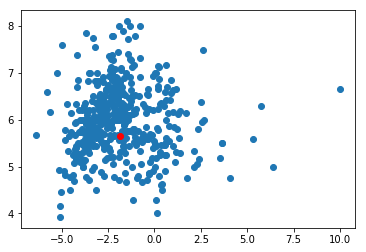

In [41]:
plt.scatter(x='b_white', y='mean_fitted', data=samp_results)
plt.scatter(x=samp_results.b_white.mean(), y=samp_results.mean_fitted.mean(), color='r')

### The mixed effects model

In [445]:
# slide 35
rim_closeblk2 = smf.mixedlm('closeblk ~ white + pct_black + age + n_year', data=sub, 
                            groups=sub['sampyear'], re_formula='~white').fit(reml=False)
rim_closeblk2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:              MixedLM  Dependent Variable:  closeblk   
No. Observations:   11260    Method:              ML         
No. Groups:         792      Scale:               3.5103     
Min. group size:    1        Likelihood:          -23187.1553
Max. group size:    107      Converged:           Yes        
Mean group size:    14.2                                     
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          6.517    0.151  43.131 0.000  6.221  6.814
white             -1.993    0.065 -30.786 0.000 -2.120 -1.866
pct_black          0.009    0.001   5.935 0.000  0.006  0.012
age               -0.010    0.001  -9.364 0.000 -0.012 -0.008
n_year             0.038    0.004   9.338 0.000  0.030  0.046
Group Var          0.337    0.046                            
Group x white Cov -0.316    0.049                            
white Var          0.359    0.060                            
=============================================================

"""

In [414]:
print(f'sigma_u_intercept: {round(np.sqrt(rim_closeblk2.cov_re.iloc[0, 0]), 5)}')
print(f'sigma_u_white: {round(np.sqrt(rim_closeblk2.cov_re.iloc[1, 1]), 5)}')
print(f'sigma_e: {round(np.sqrt(rim_closeblk2.resid.var()), 5)}')

sigma_u_intercept: 0.5804
sigma_u_white: 0.59897
sigma_e: 1.85365


In [418]:
# slide 39
rim_closeblk2_re = rim_closeblk2.random_effects

# make array of all random effect intercepts
re_intercepts = np.asarray([i[0] for i in rim_closeblk2_re.values()])

# make an array of all random effect slopes
re_slopes = np.asarray([i[1] for i in rim_closeblk2_re.values()])

# compute correlation
np.corrcoef(re_intercepts, re_slopes)

array([[ 1.        , -0.88044514],
       [-0.88044514,  1.        ]])

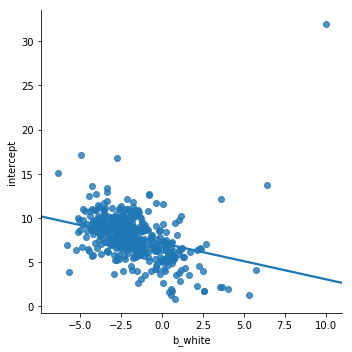

In [42]:
sns.lmplot(x='b_white', y='intercept', data=samp_results, ci=False)

### Are random slopes necessary?

Since the `mixedlm` module does not come with an anova method, we can calculate the chi-sq statistic and associated p-value by hand:

In [473]:
chisq = -2*rim_closeblk1.llf + 2*rim_closeblk2.llf

# degree of freedom in model1 - degree of freedom in model2
deg_fr = (rim_closeblk1.df_resid - rim_closeblk1.df_modelwc) - (rim_closeblk2.df_resid - rim_closeblk2.df_modelwc)

In [474]:
from scipy import stats

# p-value
1 - stats.chi2.cdf(chisq, deg_fr)

1.667863624987831e-08

## Adding cross-level interaction

In [452]:
# slide 47
rim_closeblk3 = smf.mixedlm('closeblk ~ white*pct_black + age + n_year', data=sub, 
                            groups=sub['sampyear'], re_formula='~white').fit(reml=False)
rim_closeblk3.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:              MixedLM  Dependent Variable:  closeblk   
No. Observations:   11260    Method:              ML         
No. Groups:         792      Scale:               3.5123     
Min. group size:    1        Likelihood:          -23183.8644
Max. group size:    107      Converged:           Yes        
Mean group size:    14.2                                     
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          6.753    0.175  38.648 0.000  6.410  7.095
white             -2.229    0.111 -20.035 0.000 -2.447 -2.011
pct_black          0.001    0.003   0.437 0.662 -0.005  0.008
white:pct_black    0.009    0.004   2.589 0.010  0.002  0.016
age               -0.010    0.001  -9.290 0.000 -0.012 -0.008
n_year             0.037    0.004   9.175 0.000  0.029  0.045
Group Var          0.297    0.045                            
Group x white Cov -0.286    0.048                            
white Var          0.338    0.059                            
=============================================================

"""

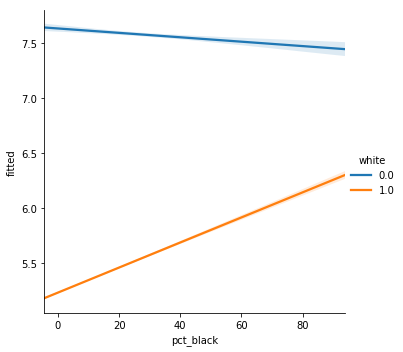

In [464]:
# slide 49
plotdata = sub[['sampyear', 'pct_black', 'white']].copy()
plotdata['fitted'] = rim_closeblk3.fittedvalues

sns.lmplot(x='pct_black', y='fitted', hue='white', data=plotdata, scatter=False)